<h1 style="font-size:300%;color:#006bd0"><center><strong>RAIN FORECAST</strong></center></h1>

# Import des modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
%matplotlib inline

## Modules pour le machine learning et le preprocessing

In [23]:
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.metrics import balanced_accuracy_score, accuracy_score

from sklearn.model_selection import GridSearchCV

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from imblearn.combine import SMOTEENN

import warnings
warnings.filterwarnings("ignore")


# Importation du jeu de données

In [24]:
df = pd.read_csv('https://assets-datascientest.s3-eu-west-1.amazonaws.com/de/total/rains.csv', index_col=[1,0])

df.head()

MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
Location  Date                                                            
Newcastle 2008-12-01     13.2      NaN       0.0          NaN       NaN   
          2008-12-02      NaN     32.2       0.0          NaN       NaN   
          2008-12-03     16.2     32.2       0.0          NaN       NaN   
          2008-12-04     19.2     24.0       0.0          NaN       NaN   
          2008-12-05     18.8     30.2       0.0          NaN       NaN   

                     WindGustDir  WindGustSpeed WindDir9am WindDir3pm  \
Location  Date                                                          
Newcastle 2008-12-01         NaN            NaN         NW         NW   
          2008-12-02         NaN            NaN        NaN         NE   
          2008-12-03         NaN            NaN          N         SE   
          2008-12-04         NaN            NaN         SE         SE   
          2008-12-05         NaN            NaN         NE        NaN   

                      WindSpeed9am  ...  Humidity9am  Humidity3pm  \
Location  Date                      ...                             
Newcastle 2008-12-01           6.0  ...         50.0         24.0   
          2008-12-02           NaN  ...          NaN         59.0   
          2008-12-03           2.0  ...         74.0         26.0   
          2008-12-04          22.0  ...         66.0         61.0   
          2008-12-05           4.0  ...         85.0          NaN   

                      Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  \
Location  Date                                                                
Newcastle 2008-12-01          NaN          NaN       3.0       4.0     21.8   
          2008-12-02          NaN          NaN       NaN       0.0      NaN   
          2008-12-03          NaN          NaN       4.0       4.0     22.2   
          2008-12-04          NaN          NaN       7.0       5.0     20.4   
          2008-12-05          NaN          NaN       8.0       NaN     20.0   

                      Temp3pm  RainToday RainTomorrow  
Location  Date                                         
Newcastle 2008-12-01     30.6         No           No  
          2008-12-02     25.4         No           No  
          2008-12-03     32.0         No           No  
          2008-12-04     23.0         No           No  
          2008-12-05      NaN         No           No  

[5 rows x 21 columns]

In [25]:
print(df.shape)
print(df.index.get_level_values(0).unique().tolist())
print(df.index.get_level_values(1).min(), '->' , df.index.get_level_values(1).max())

(25631, 21)
['Newcastle', 'Sydney', 'Canberra', 'Melbourne', 'Brisbane', 'GoldCoast', 'Adelaide', 'Perth']
2007-11-01 -> 2017-06-25


Le jeux de données contient **25 631** observations constituées de **21** colonnes concernant **8** villes australiennes du 2007 au 2017.

La variable cible est *RainTomorrow*. Il s'agît d'une variable discrète qui peut prendre 2 valeurs (Yes/No) : le problème est donc un problème de **classification binaire**. 

Des 20 features, 17 sont des variables quantitatives et 3 qualitatives (*WindGustDir*, *WindDir9am*, *WindDir3pm*).

# Analyse et préparation des données

In [26]:
df.isna().any(axis=1).sum() / len(df)

0.5847216261558269

**58%** des observations contiennent au moins une valeure manquantes !

In [27]:
print(df["RainTomorrow"].isna().sum())
df = df[-df["RainTomorrow"].isna()]

1062


**1062** observations n'ont pas de valeur pour la variable cible. Nous commençons donc par éliminer ces observations.

Analyse de la répartition du nombre de variable manquante par observations

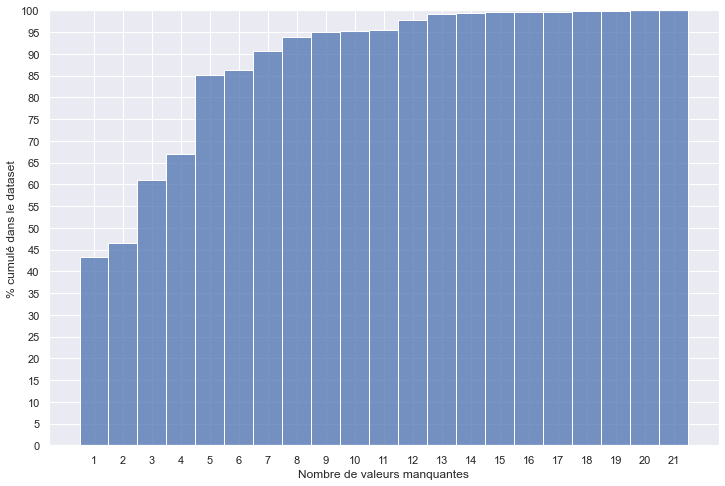

In [28]:
plt.figure(figsize=(12,8))
b = sns.histplot(
    x=df.isna().sum(axis=1)+1,
    cumulative=True, 
    stat="percent", 
    bins=len(df.columns),
    discrete=True
)
b.set_xticks(np.arange(1, len(df.columns)+1))
b.set_yticks(np.arange(0,101, 5))
b.set_ylim(0,100)
b.set_xlabel("Nombre de valeurs manquantes")
b.set_ylabel("% cumulé dans le dataset")
b.xaxis.grid(True);

Nous pouvons voir que si nous supprimons les observations ayant plus de 6 variables manquantes nous garderions encore 90% du jeux de données.  
Supprimer les observations ayant un nombre trop important de variables manquantes permet d'éviter trop de biais lors de la modélisation en remplaçant ces valeurs.

Suppression des observations avec plus de 6 variables manquantes

In [29]:
df = df[df.isna().sum(axis=1) < 7]
df.shape

(22268, 21)

Nous avons maintenant un jeu de 22 268 observations

Observons maintenant quelles est la distribution des valeurs manquantes par variable.

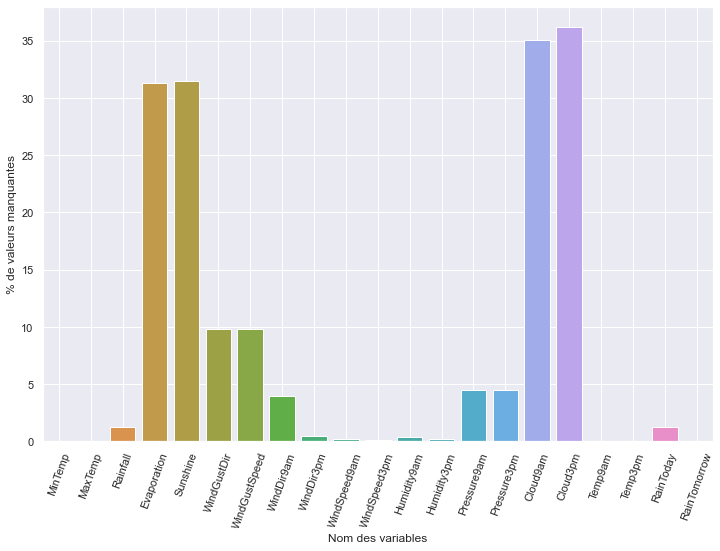

In [30]:
plt.figure(figsize=(12,8))
b = sns.barplot(x=df.columns, y=df.isna().sum() / len(df) * 100)
b.set_xticklabels(b.get_xticklabels(), rotation=70)
b.set_xlabel("Nom des variables")
b.set_ylabel("% de valeurs manquantes")
b.xaxis.grid(True);

Nous pouvons voir qu'il y a 4 variables qui sont absentes dans plus d'un tiers des observations : *Evaporation*, *Sunshine*, *Cloud9am* et *Cloud3pm*.

Observons la distribution de leur absence par ville.

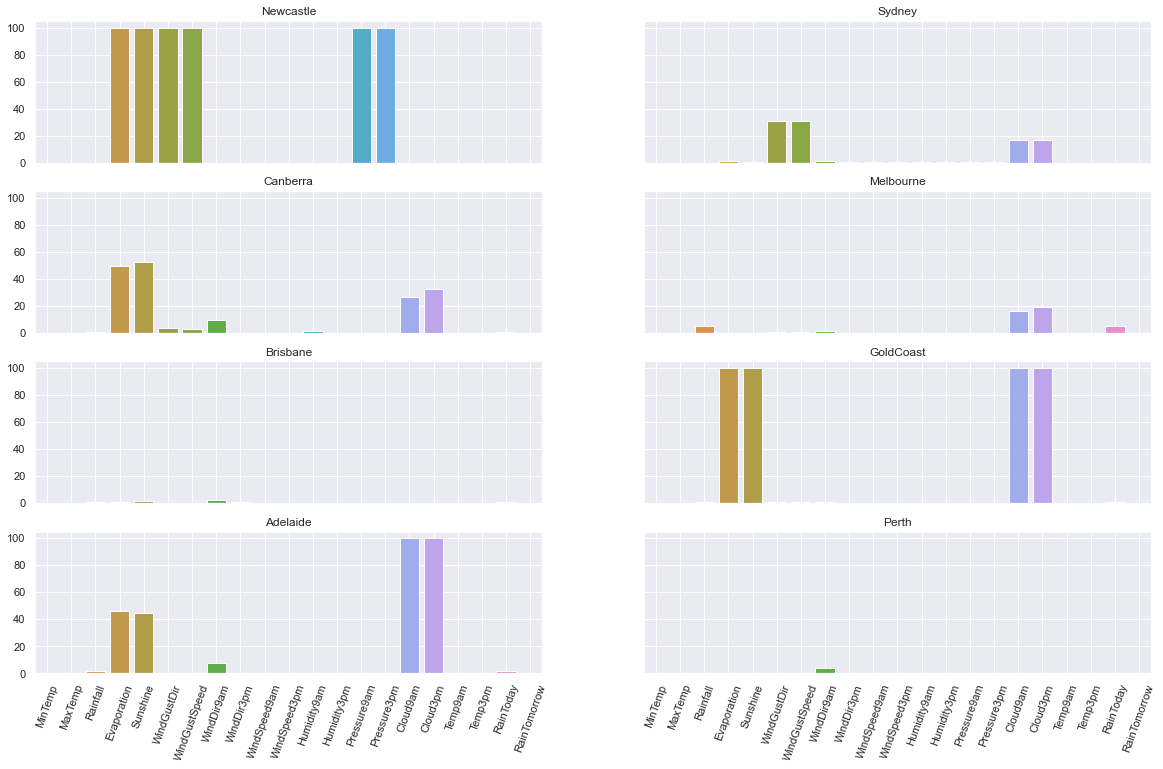

In [31]:
fig, ax = plt.subplots(4,2, sharex=True, sharey=True, figsize=(20,12))

for i, location in enumerate(df.index.get_level_values(0).unique()):
    b = sns.barplot(x=df.columns, y=df.loc[location].isna().sum() / len(df.loc[location]) * 100, ax=ax[int(i/2),i%2])
    b.set_xticklabels(b.get_xticklabels(), rotation=70)
    b.set_title(location)
    b.xaxis.grid(True)


On peut observer que, pour les villes de Newcastle et Perth il n'y a pas du tout de données concernant ces 4 variables. Il paraît donc difficile de reconstruire leur valeur sur la base d'une interpolation ou d'une valeur moyenne. Nous décidons par conséquent d'éliminer ces 4 variables du jeu de données.

In [32]:
df = df.drop(["Evaporation", "Sunshine", "Cloud9am", "Cloud3pm"], axis=1)
df.shape

(22268, 17)

Nous avons maintenant un jeu de 22 268 observations avec encore des Nans. Nous décidons de remplacer ces valeurs par une interpolation temporelle ville par ville. 

Cependant, avant, il est nécessaire avant de transformer les variables qualitatives en valeurs quantitatives.

In [33]:
dict_val = {
    'N'     : 0,
    'NNE'   : 22.5,
    'NE'    : 45,
    'ENE'   : 67.5,
    'E'     : 90,
    'ESE'   : 112.5,
    'SE'    : 135,
    'SSE'   : 157.5,
    'S'     : 180,
    'SSW'   : 202.5,
    'SW'    : 225,
    'WSW'   : 247.5,
    'W'     : 270,
    'WNW'	: 292.5,
    'NW'	: 315,
    'NNW'	: 337.5,
    'N'	    : 360,

    'Yes'   : 1,
    'No'    : 0
}

df = df.replace(dict_val)

In [34]:
new_df = pd.DataFrame()
for location in df.index.get_level_values(0).unique():
    df_location = df.loc[location]
    df_location.index = pd.DatetimeIndex(df_location.index)
    df_location = df_location.interpolate(method='time').dropna().reset_index() #Drop first line, if first line is a Nan
    df_location['Location'] = location
    new_df = pd.concat([new_df, df_location])

df = new_df.set_index(['Location', 'Date'])
df.shape

(20327, 17)

Pour terminer la préparation des données, nous ajoutons une variable raprésentant le mois de l'observation, qui a une influence sur la variable cible.

In [35]:
df['Month'] = df.index.get_level_values(1).month
df.shape

(20327, 18)

Nous avons maintenant un jeu de données propre composé de **20 327** observations et **18** variables. 

Nous séparons le jeu de données en variable explicative **X** et variable cible **y**

In [36]:
X = df.drop(columns="RainTomorrow")
y = df['RainTomorrow']

# Modélisation

Nous allons comparer dans cette partie la performance de différents modèles de classification binaire, en faisant varier leurs hyperparamètres (**hyperparameter tuning**).

Pour cela, nous utilisons la fonction **GridSearchCV** de Scikit Learn.

In [37]:
def models_accuracy(X, y, sampler, models, params):
    """Function to find the better model and the best parameters."""
    resample = sampler
    X_res, y_res = resample.fit_resample(X, y)
    X_train,  X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

    # Creation of a pipeline to scale the values and apply the model.
    pipe = Pipeline(steps=[('preprocessor', MinMaxScaler()),
                           ('m', models)])

    # Tool to find the best parameters for a model.
    grid = GridSearchCV(pipe, 
                        param_grid=params, 
                        scoring=["accuracy", "balanced_accuracy"], 
                        n_jobs=2,
                        refit="balanced_accuracy",
                        verbose=0)

    # Training.
    grid.fit(X_train, y_train)
    accuracy_train = np.median([x for x in grid.cv_results_["mean_test_accuracy"] if pd.isnull(x) == False])
    balanced_accuracy_train = np.median([x for x in grid.cv_results_["mean_test_balanced_accuracy"] if pd.isnull(x) == False])

    # Test.
    grid_predict = grid.predict(X_test)
    accuracy_test = accuracy_score(y_test, grid_predict)
    balanced_accuracy_test = balanced_accuracy_score(y_test, grid_predict)

    # Resultat with the best parameters and the accuracy score 
    # and balanced accuracy score for both training and test
    result = (grid.best_params_, accuracy_train, balanced_accuracy_train,
    accuracy_test, balanced_accuracy_test, pd.crosstab(y_test, grid_predict))

    return result
    

Nous avons selectionné 5 modèles de classification à comparer :
- Arbre de décision
- Gradient Boosting
- Classificateur bayesien 
- Régression logistique
- KNN

In [38]:
models_to_compare = {
    'Decision Tree Classifier' : DecisionTreeClassifier(class_weight="balanced"), 
    'Gradient Boosting Classifier' : GradientBoostingClassifier(),
    'Gaussian NB' : GaussianNB(),
    'Logistic Regression' : LogisticRegression(max_iter=10000, n_jobs=1, class_weight="balanced"),
    'KNN' : KNeighborsClassifier(n_jobs=1)
}

Pour chaque modèle, nous avons défini une combinaison d'hyperparamètres à faire tester par GridSearchCV

In [39]:
params_for_models = [
        [{"m__criterion": ["gini", "entropy"],
        "m__splitter": ["best", "random"],
        "m__min_samples_split": np.arange(2, 6),
        "m__min_samples_leaf": np.arange(2, 6)
        }],
        [{"m__loss": ["deviance", "exponential"],
        "m__learning_rate": np.arange(0.1, 0.5, 0.1),
        "m__n_estimators": np.arange(100, 160, 10),
        }],
        [{                    
        }],   
        [{"m__penalty": ["l1", "l2", "elasticnet", "none"],
        "m__solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]}],
        [{"m__n_neighbors": np.arange(5, 10),
        "m__weights": ["uniform", "distance"],
        "m__algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
        }]
]


Nous vérifions si le jeux de données est équilibré :

In [106]:
rain = pd.DataFrame(y)

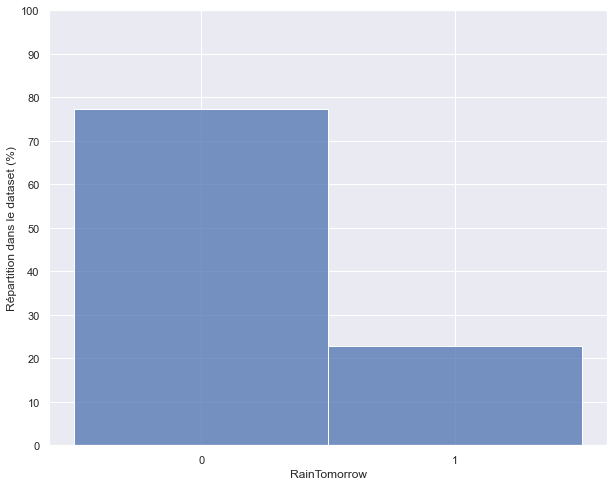

In [107]:
plt.figure(figsize=(10,8))
b = sns.histplot(
    rain.RainTomorrow,
    stat="percent",
    discrete=True
)
b.set_xticks([0,1])
b.set_yticks(np.arange(0,101, 10))
b.set_ylim(0,100)
b.set_xlabel("RainTomorrow")
b.set_ylabel("Répartition dans le dataset (%)")
b.xaxis.grid(True);

On peut voir qu'il y a beaucoup plus de jours sans pluie (0) que des jours avec pluie (1). 

Pour compenser ce désequilibre, nous allons tester différents méthodes d'over-sampling et under-sampling :

In [41]:
samplers_to_compare = {
    "Random Over Sampler": RandomOverSampler(),
    "SMOTE": SMOTE(random_state=42),
    "Random Under Sampler": RandomUnderSampler(),
    "Cluster Centroids": ClusterCentroids(),
    "SMOTEENN": SMOTEENN()
}

## Recherche du modèle plus performant avec la méthode **RandomOverSampling**

In [42]:
for samp_name, samp in samplers_to_compare.items():
    if samp_name == "Random Over Sampler":
        for param, (name, model) in zip(params_for_models, models_to_compare.items()):
            res = models_accuracy(X, y, samp, model, param)
            print(f'Modèle: {name} - sampler: {samp_name}\n\
Meilleurs paramètres : {res[0]}\n\
Accuracy (train) : {res[1]}\n\
Balanced accuracy (train) : {res[2]}\n\
Accuracy (test) : {res[3]}\n\
Balanced accuracy (test) : {res[4]}\n\
Matrice de confusion :\n\
{res[5]}\n\n')
    

Modèle: Decision Tree Classifier - sampler: Random Over Sampler
Meilleurs paramètres : {'m__criterion': 'entropy', 'm__min_samples_leaf': 2, 'm__min_samples_split': 4, 'm__splitter': 'best'}
Accuracy (train) : 0.8316204473201632
Balanced accuracy (train) : 0.831514863181996
Accuracy (test) : 0.8796816976127321
Balanced accuracy (test) : 0.8802344566353187
Matrice de confusion :
col_0            0     1
RainTomorrow            
0             4040   745
1              389  4251


Modèle: Gradient Boosting Classifier - sampler: Random Over Sampler
Meilleurs paramètres : {'m__learning_rate': 0.4, 'm__loss': 'deviance', 'm__n_estimators': 150}
Accuracy (train) : 0.8141571835276089
Balanced accuracy (train) : 0.8142157281912483
Accuracy (test) : 0.8426525198938992
Balanced accuracy (test) : 0.8426430250783699
Matrice de confusion :
col_0            0     1
RainTomorrow            
0             4035   750
1              733  3907


Modèle: Gaussian NB - sampler: Random Over Sampler
Meilleurs

Le modèle ayant le meilleur résultat avec le **RandomOverSampling** est la méthode des `K Nearest Neighboors` avec  comme paramètres :

`{'m__algorithm': 'auto', 'm__n_neighbors': 8, 'm__weights': 'distance'}`

Balanced accuracy (train) : **83%**  
Balanced accuracy (test) : **88%**

## Recherche du modèle plus performant avec la méthode **SMOTE**

In [43]:
for samp_name, samp in samplers_to_compare.items():
    if samp_name == "SMOTE":
        for param, (name, model) in zip(params_for_models, models_to_compare.items()):
            res = models_accuracy(X, y, samp, model, param)
            print(f'Modèle: {name} - sampler: {samp_name}\n\
Meilleurs paramètres : {res[0]}\n\
Accuracy (train) : {res[1]}\n\
Balanced accuracy (train) : {res[2]}\n\
Accuracy (test) : {res[3]}\n\
Balanced accuracy (test) : {res[4]}\n\
Matrice de confusion :\n\
{res[5]}\n')

Modèle: Decision Tree Classifier - sampler: SMOTE
Meilleurs paramètres : {'m__criterion': 'entropy', 'm__min_samples_leaf': 3, 'm__min_samples_split': 4, 'm__splitter': 'best'}
Accuracy (train) : 0.8076312004453821
Balanced accuracy (train) : 0.8077643167647385
Accuracy (test) : 0.8270557029177719
Balanced accuracy (test) : 0.8269461859979101
Matrice de confusion :
col_0            0     1
RainTomorrow            
0             3991   794
1              836  3804

Modèle: Gradient Boosting Classifier - sampler: SMOTE
Meilleurs paramètres : {'m__learning_rate': 0.4, 'm__loss': 'exponential', 'm__n_estimators': 150}
Accuracy (train) : 0.890240860407221
Balanced accuracy (train) : 0.890390690388977
Accuracy (test) : 0.9009018567639258
Balanced accuracy (test) : 0.9005583855799373
Matrice de confusion :
col_0            0     1
RainTomorrow            
0             4416   369
1              565  4075

Modèle: Gaussian NB - sampler: SMOTE
Meilleurs paramètres : {}
Accuracy (train) : 0.7403

Le modèle ayant le meilleur résultat avec le **SMOTE** est la méthode du `Gradient Boosting` avec les paramètres suivants :

`{'m__learning_rate': 0.4, 'm__loss': 'exponential', 'm__n_estimators': 150}`

Balanced accuracy (train) : **89%**  
Balanced accuracy (test) : **90%**

## Recherche du modèle plus performant avec la méthode **RandomUnderSampling**

In [44]:
for samp_name, samp in samplers_to_compare.items():
    if samp_name == "Random Under Sampler":
        for param, (name, model) in zip(params_for_models, models_to_compare.items()):
            res = models_accuracy(X, y, samp, model, param)
            print(f'Modèle: {name} - sampler: {samp_name}\n\
Meilleurs paramètres : {res[0]}\n\
Accuracy (train) : {res[1]}\n\
Balanced accuracy (train) : {res[2]}\n\
Accuracy (test) : {res[3]}\n\
Balanced accuracy (test) : {res[4]}\n\
Matrice de confusion :\n\
{res[5]}\n')

Modèle: Decision Tree Classifier - sampler: Random Under Sampler
Meilleurs paramètres : {'m__criterion': 'gini', 'm__min_samples_leaf': 5, 'm__min_samples_split': 4, 'm__splitter': 'random'}
Accuracy (train) : 0.7147506308490253
Balanced accuracy (train) : 0.7147835797820453
Accuracy (test) : 0.727994227994228
Balanced accuracy (test) : 0.7277421652421653
Matrice de confusion :
col_0            0    1
RainTomorrow           
0             1049  355
1              399  969

Modèle: Gradient Boosting Classifier - sampler: Random Under Sampler
Meilleurs paramètres : {'m__learning_rate': 0.2, 'm__loss': 'deviance', 'm__n_estimators': 140}
Accuracy (train) : 0.7785252536843854
Balanced accuracy (train) : 0.7786230999105804
Accuracy (test) : 0.7972582972582972
Balanced accuracy (test) : 0.7971022642075274
Matrice de confusion :
col_0            0     1
RainTomorrow            
0             1136   268
1              294  1074

Modèle: Gaussian NB - sampler: Random Under Sampler
Meilleurs par

Le modèle ayant le meilleur résultat avec le **RandomUnderSampling** est la méthode du `Gradient Boosting` avec les paramètres suivantes :  

`{'m__learning_rate': 0.2, 'm__loss': 'deviance', 'm__n_estimators': 140}`

Balanced accuracy (train) : **78%**  
Balanced accuracy (test) : **80%**

## Recherche du modèle plus performant avec la méthode **ClusterCentroids**

In [45]:
for samp_name, samp in samplers_to_compare.items():
    if samp_name == "Cluster Centroids":
        for param, (name, model) in zip(params_for_models, models_to_compare.items()):
            res = models_accuracy(X, y, samp, model, param)
            print(f'Modèle: {name} - sampler: {samp_name}\n\
Meilleurs paramètres : {res[0]}\n\
Accuracy (train) : {res[1]}\n\
Balanced accuracy (train) : {res[2]}\n\
Accuracy (test) : {res[3]}\n\
Balanced accuracy (test) : {res[4]}\n\
Matrice de confusion :\n\
{res[5]}\n')

Modèle: Decision Tree Classifier - sampler: Cluster Centroids
Meilleurs paramètres : {'m__criterion': 'gini', 'm__min_samples_leaf': 5, 'm__min_samples_split': 5, 'm__splitter': 'random'}
Accuracy (train) : 0.7617499291751686
Balanced accuracy (train) : 0.7618499707696528
Accuracy (test) : 0.7817460317460317
Balanced accuracy (test) : 0.7816951566951567
Matrice de confusion :
col_0            0     1
RainTomorrow            
0             1103   301
1              304  1064

Modèle: Gradient Boosting Classifier - sampler: Cluster Centroids
Meilleurs paramètres : {'m__learning_rate': 0.4, 'm__loss': 'deviance', 'm__n_estimators': 130}
Accuracy (train) : 0.8583798625579897
Balanced accuracy (train) : 0.8582631524717536
Accuracy (test) : 0.8683261183261183
Balanced accuracy (test) : 0.8686647173489279
Matrice de confusion :
col_0            0     1
RainTomorrow            
0             1183   221
1              144  1224

Modèle: Gaussian NB - sampler: Cluster Centroids
Meilleurs paramèt

Le modèle ayant le meilleur résultat avec le **ClusterCentroids** est la méthode du `Gradient Boosting` avec les paramètres suivants :  

`{'m__learning_rate': 0.4, 'm__loss': 'deviance', 'm__n_estimators': 130}`

Balanced accuracy (train) : **86%**  

Balanced accuracy (test) : **87%**

## Recherche du modèle plus performant avec la méthode **SMOTEENN** (combine Over-sampling et Under-sampling)

In [46]:
for samp_name, samp in samplers_to_compare.items():
    if samp_name == "SMOTEENN":
        for param, (name, model) in zip(params_for_models, models_to_compare.items()):
            res = models_accuracy(X, y, samp, model, param)
            print(f'Modèle: {name} - sampler: {samp_name}\n\
Meilleurs paramètres : {res[0]}\n\
Accuracy (train) : {res[1]}\n\
Balanced accuracy (train) : {res[2]}\n\
Accuracy (test) : {res[3]}\n\
Balanced accuracy (test) : {res[4]}\n\
Matrice de confusion :\n\
{res[5]}\n')

Modèle: Decision Tree Classifier - sampler: SMOTEENN
Meilleurs paramètres : {'m__criterion': 'entropy', 'm__min_samples_leaf': 2, 'm__min_samples_split': 2, 'm__splitter': 'best'}
Accuracy (train) : 0.8709041262135921
Balanced accuracy (train) : 0.8696012071190647
Accuracy (test) : 0.8897225368063421
Balanced accuracy (test) : 0.8879950228276419
Matrice de confusion :
col_0            0     1
RainTomorrow            
0             2619   368
1              411  3666

Modèle: Gradient Boosting Classifier - sampler: SMOTEENN
Meilleurs paramètres : {'m__learning_rate': 0.4, 'm__loss': 'deviance', 'm__n_estimators': 150}
Accuracy (train) : 0.9341441167528124
Balanced accuracy (train) : 0.9333180335663053
Accuracy (test) : 0.9391403035891616
Balanced accuracy (test) : 0.9384027062488344
Matrice de confusion :
col_0            0     1
RainTomorrow            
0             2794   199
1              230  3826

Modèle: Gaussian NB - sampler: SMOTEENN
Meilleurs paramètres : {}
Accuracy (train) 

Le modèle ayant le meilleur résultat avec le **SMOTEENN** est la méthode du `Gradient Boosting` :  

`{'m__learning_rate': 0.4, 'm__loss': 'deviance', 'm__n_estimators': 150}`

Balanced accuracy (train) : **93%**  

Balanced accuracy (test) : **94%** 

Au vue des résultat le modèle plus performant est le **GradientBoostingClassifier** avec un reéchantillonage avec la méthode du **SMOTEENN**.  

L'accuracy du modèle sur le jeu de données de test est de **94%**. 

